# Import the Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,accuracy_score
from keras.layers import concatenate
from keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten,Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers



# Data Collection


In [2]:
!mkdir "/tmp/X-RAY/"

In [3]:
!mkdir -p tmp/X-RAY/COVID
!mkdir -p tmp/X-RAY/LUNG_OPACITY
!mkdir -p tmp/X-RAY/NORMAL
!mkdir -p tmp/X-RAY/PNEUMONIA

In [20]:
!cp /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/*.png tmp/X-RAY/COVID/
!cp /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/*.png tmp/X-RAY/NORMAL/
!cp /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images/*.png tmp/X-RAY/LUNG_OPACITY/
!cp /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral\ Pneumonia/images/*.png tmp/X-RAY/PNEUMONIA/


In [21]:
!ls tmp/X-RAY/

COVID  LUNG_OPACITY  NORMAL  PNEUMONIA


# Data Preprocessing

In [22]:
dataset_dir = "tmp/X-RAY/"

categories = ["COVID", "LUNG_OPACITY", "NORMAL", "PNEUMONIA"]
image_counts = {}

for category in categories:
    category_path = os.path.join(dataset_dir, category)
    image_counts[category] = len(os.listdir(category_path))

print(image_counts)


{'COVID': 3616, 'LUNG_OPACITY': 6012, 'NORMAL': 10192, 'PNEUMONIA': 1345}


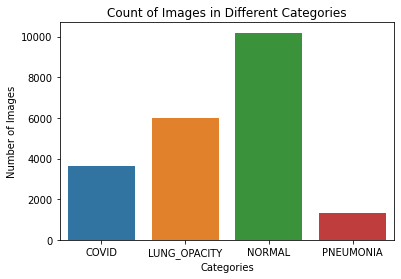

In [23]:
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))

plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.title("Count of Images in Different Categories")
plt.show()

# Data Augmentation

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_path="tmp/X-RAY/"

In [25]:
train_datagen = ImageDataGenerator(rescale=1/255,zoom_range=0.2,shear_range=0.2,validation_split=0.2)

In [26]:
train=train_datagen.flow_from_directory(train_path,target_size=(299,299),batch_size=16,subset='training',class_mode='categorical')# input pixels of images trained for VGGnet
test=train_datagen.flow_from_directory(train_path,target_size=(299,299),batch_size=16,subset='validation',class_mode='categorical')

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


In [27]:
from tensorflow.keras.applications import Xception
excep= Xception(include_top=False,input_shape=(299,299,3))

In [28]:
for layer in excep.layers:
    layer.trainable=False

In [29]:
x = Flatten()(excep.output)
output=Dense(4,activation='softmax')(x)

In [30]:
exp_model=Model(excep.input,output)
exp_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=(['accuracy']))
exp_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [31]:
from keras.callbacks import EarlyStopping
EarlyStopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=.01,
                              patience=6,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

# Model Training

In [33]:
epochs = 20  
batch_size  = 32
exp_history = exp_model.fit(train,
                              steps_per_epoch = 16933 // batch_size,
                              epochs = 20,
                              validation_data = test,
                              callbacks=[EarlyStopping])

Epoch 1/20
529/529 [==============================] - 245s 459ms/step - loss: 3.9786 - accuracy: 0.7375 - val_loss: 2.3226 - val_accuracy: 0.8388
Epoch 2/20
529/529 [==============================] - 240s 454ms/step - loss: 3.1422 - accuracy: 0.8041 - val_loss: 4.1307 - val_accuracy: 0.8119
Epoch 3/20
529/529 [==============================] - 244s 461ms/step - loss: 2.8580 - accuracy: 0.8296 - val_loss: 4.0558 - val_accuracy: 0.8157
Epoch 4/20
529/529 [==============================] - 248s 468ms/step - loss: 2.9164 - accuracy: 0.8302 - val_loss: 3.2768 - val_accuracy: 0.8346
Epoch 5/20
529/529 [==============================] - 251s 474ms/step - loss: 2.8200 - accuracy: 0.8503 - val_loss: 3.6206 - val_accuracy: 0.8611
Epoch 6/20
529/529 [==============================] - 247s 467ms/step - loss: 2.9947 - accuracy: 0.8536 - val_loss: 3.7535 - val_accuracy: 0.8379
Epoch 7/20
529/529 [==============================] - 245s 463ms/step - loss: 2.9342 - accuracy: 0.8582 - val_loss: 5.2996 -

# Evaluation

In [34]:
test_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)  
test_generator = test_datagen.flow_from_directory(
    "tmp/X-RAY/",
    target_size=(299,299),   
    batch_size=64,
    class_mode='categorical',  # Change to 'binary' for binary classification
    shuffle=False,  # Ensure no shuffling for consistent evaluation
    subset='validation'   
)

Found 4232 images belonging to 4 classes.


In [35]:
y_pred = exp_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 84.07%


In [36]:
class_names = ['COVID', 'LUNG_OPACITY','NORMAL', 'PNEUMONIA']
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       COVID       0.91      0.76      0.83       723
LUNG_OPACITY       0.92      0.68      0.79      1202
      NORMAL       0.79      0.98      0.87      2038
   PNEUMONIA       0.95      0.71      0.81       269

    accuracy                           0.84      4232
   macro avg       0.89      0.78      0.83      4232
weighted avg       0.86      0.84      0.84      4232



# Evaluation Graphs

In [37]:
training_loss = exp_history.history['loss']
validation_loss = exp_history.history['val_loss']

training_accuracy = exp_history.history['accuracy']
validation_accuracy = exp_history.history['val_accuracy']

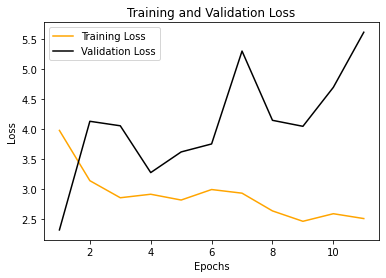

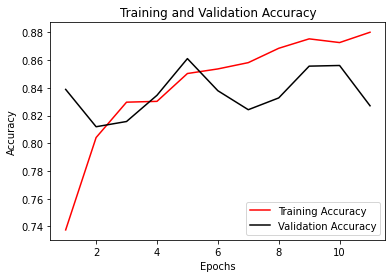

In [38]:
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'orange', label='Training Loss')
plt.plot(epochs, validation_loss, 'k', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, training_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'k', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [39]:
import pandas as pd
names=["COVID","LUNG_OPACITY","NORMAL","PNEUMONIA"]
confusion_mat=pd.crosstab(y_true, y_pred_classes)
confusion_mat.columns=names
confusion_mat.index=names
confusion_mat

,COVID,LUNG_OPACITY,NORMAL,PNEUMONIA
COVID,553,44,124,2
LUNG_OPACITY,39,821,341,1
NORMAL,14,24,1993,7
PNEUMONIA,1,0,77,191
